In [1]:
import os
import shapely

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from scipy.interpolate import CubicSpline

In [2]:
centroid_path = Path(os.getenv("CENTROID_PATH"))
population_grids_path = Path(os.getenv("POPULATION_GRIDS_PATH"))
segregation_path = Path(os.getenv("SEGREGATION_PATH"))

In [3]:
def gini(accum_pop: list, accum_income: list) -> float:
    assert len(accum_income) == len(accum_pop)

    s = 0
    for i in range(1, len(accum_pop)):
        s += (accum_pop[i] - accum_pop[i - 1]) * (accum_income[i] + accum_income[i - 1])
    return 1 - s

# Global

In [4]:
name_map = (
    gpd.read_file("./data/mpios/metropoli.shp")
    .assign(CVE_SUN=lambda x: x["CVEGEO"].apply(lambda y: f"M{y[:2]}.{y[5:]}"))[
        ["CVE_SUN", "NOMGEO"]
    ]
    .drop_duplicates()
    .set_index("CVE_SUN")["NOMGEO"]
    .to_dict()
)

In [32]:
df_gini = []
for path in (segregation_path / "ecdf").glob("*.csv"):
    df_cdf = pd.read_csv(path, usecols=["w_MZ", "Ingreso_orig"])

    accum_income = (
        (df_cdf["Ingreso_orig"] / df_cdf["Ingreso_orig"].sum())
        .cumsum()
        .to_numpy()
        .tolist()
    )
    accum_pop = df_cdf["w_MZ"].to_numpy().tolist()

    accum_income = [0] + accum_income
    accum_pop = [0] + accum_pop

    df_gini.append(dict(zone=path.stem, gini=gini(accum_pop, accum_income)))


df_gini = pd.DataFrame(df_gini)
df_gini = df_gini.set_index("zone")

(0.0, 0.7)

c:\Users\lain\Documents\segregation\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


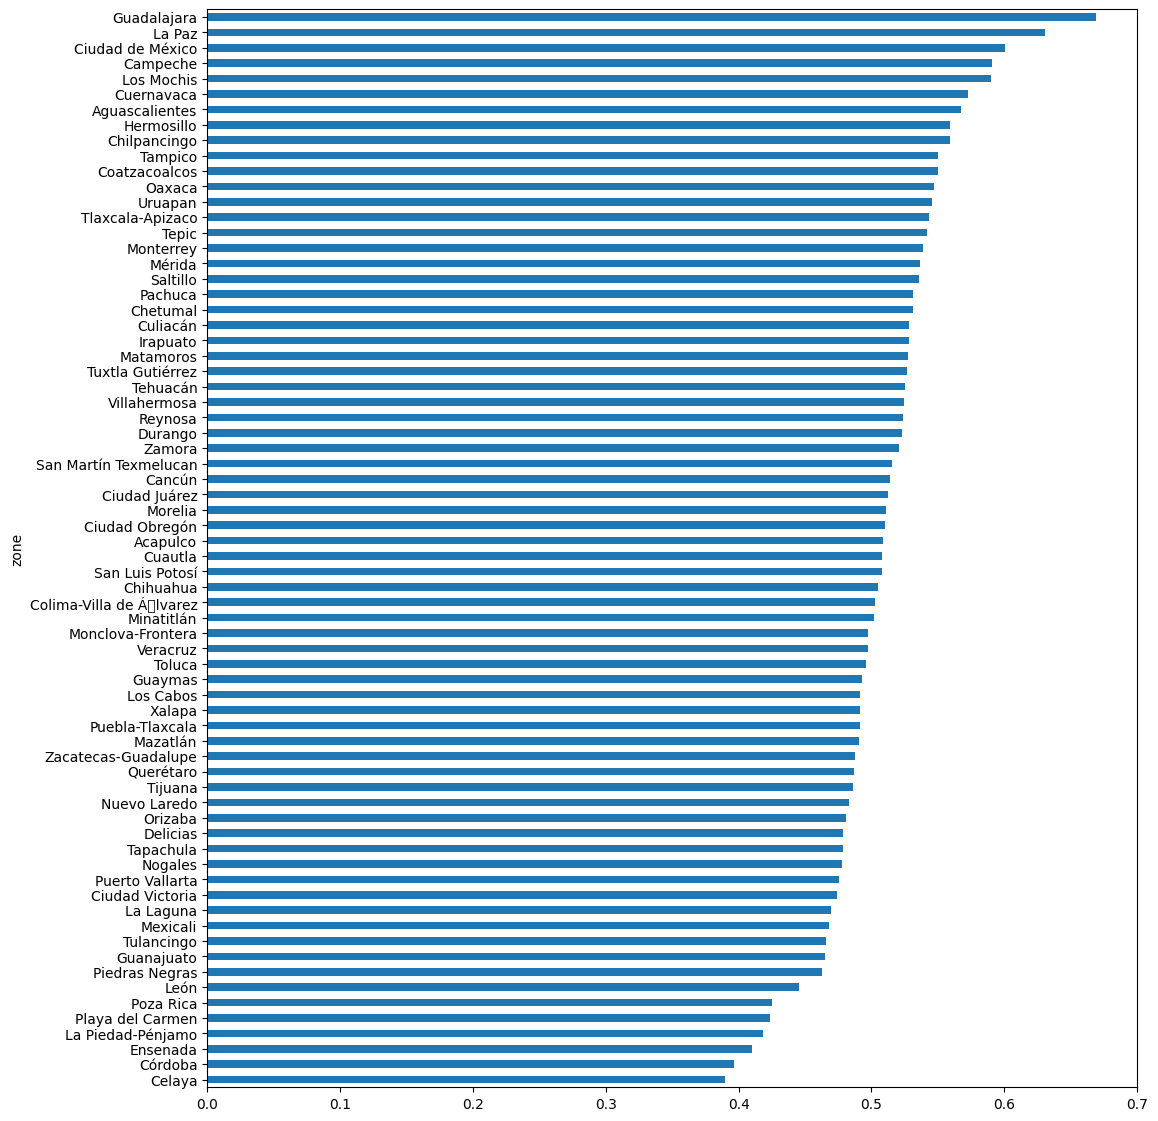

In [6]:
fig, ax = plt.subplots(figsize=(12, 14))
df_gini["gini"].sort_values().plot.barh()
ax.set_xlim(0, 0.7)

# Local

## Gini

In [8]:
df_agebs = gpd.read_file(
    population_grids_path / "final/framework/agebs/2020.gpkg"
).set_index("CVEGEO")

In [30]:
for path in (segregation_path / "ecdf").glob("*.csv"):
    df_zone = (
        pd.read_csv(path)
        .drop(columns=["w_MZ"])
        .assign(
            Ingreso_orig=lambda x: (
                x["Ingreso_orig"] / x["Ingreso_orig"].sum()
            ).cumsum()
        )
        .set_index("Ingreso_orig")
    )
    df_zone.loc[0] = 0
    df_zone = df_zone.sort_index()

    df_gini_local = (
        df_zone.apply(lambda x: gini(x.to_numpy(), x.index.to_numpy()))
        .to_frame("gini")
        .join(df_agebs["geometry"])
    )
    df_gini_local = gpd.GeoDataFrame(
        df_gini_local, geometry="geometry", crs=df_agebs.crs
    )
    df_gini_local.to_file(f"./out/gini_local/{path.stem}.gpkg")

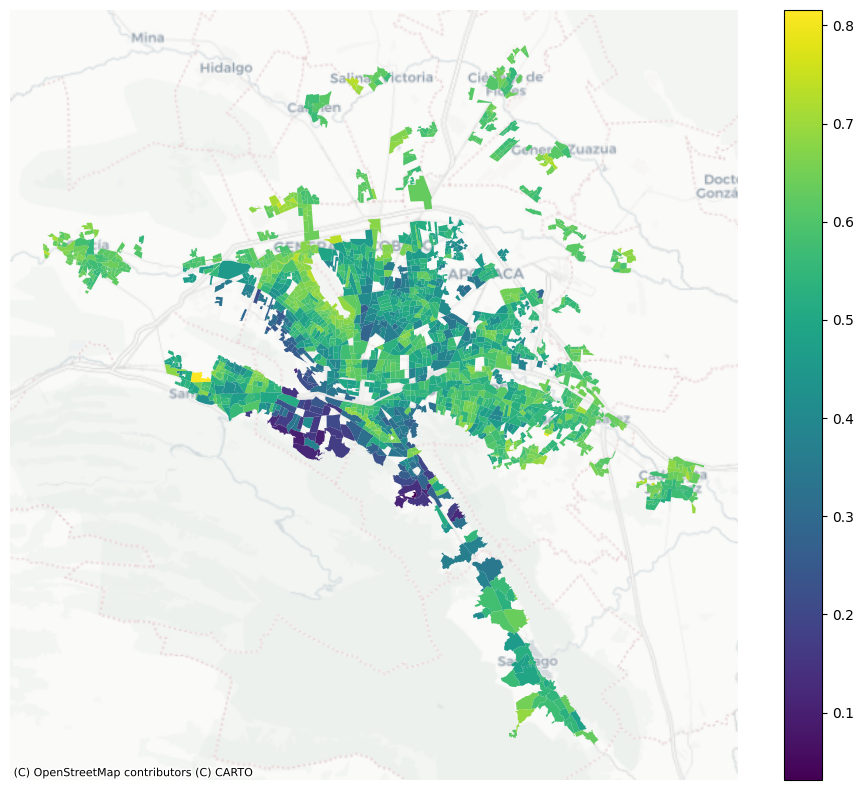

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
df_gini_local.plot(column="gini", legend=True, ax=ax)
ax.axis("off")
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=df_gini_local.crs)

# Ingreso al centro

In [11]:
def get_polygon_diagonal(geom: shapely.Polygon) -> float:
    coords = list(zip(*geom.oriented_envelope.exterior.coords.xy))

    max_r = 0
    for (start_x, start_y), (end_x, end_y) in zip(coords, coords[1:]):
        r = np.sqrt((start_x - end_x) ** 2 + (start_y - end_y) ** 2)
        if r > max_r:
            max_r = r

    return max_r


def get_max_radius(geometries: gpd.GeoSeries, centroid: shapely.Point) -> float:
    dists = geometries.distance(centroid)
    radii = geometries.apply(get_polygon_diagonal)
    return (dists + radii).max()


def generate_circles(
    geometries: gpd.GeoSeries, centroid: shapely.Point, interval: float = 250
) -> gpd.GeoDataFrame:
    max_dist = get_max_radius(geometries, centroid)

    geoms, radii = [], []
    for radius in np.arange(interval, max_dist, interval):
        geoms.append(centroid.buffer(radius, 64))
        radii.append(radius / 1000)

    df_circle = gpd.GeoDataFrame(geometry=geoms, crs=geometries.crs)
    df_circle = df_circle.assign(radius=radii)
    return df_circle


def overlay_circles(
    df_income: gpd.GeoDataFrame, df_circles: gpd.GeoDataFrame
) -> pd.DataFrame:
    overlay = (
        df_income.assign(ageb_area=lambda x: x.area)
        .overlay(df_circles)
        .assign(
            area_frac=lambda x: x.area / x["ageb_area"],
            income_frac=lambda x: x["area_frac"] * x["income_pc"],
            total_income=lambda x: x["income_frac"] * x["POBTOT"],
        )
    )

    total_income = overlay.groupby("radius")["total_income"].sum()

    for r in df_circles["radius"]:
        if r not in total_income.index:
            total_income.loc[r] = 0
    total_income.loc[0] = 0
    total_income = total_income.sort_index()
    total_income = total_income.loc[: total_income.idxmax()]

    total_income_frac = (total_income / total_income.max()).rename("total_income_frac")

    out = pd.concat([total_income, total_income_frac], axis=1)
    return out


def fit_splines(df: pd.DataFrame, norm_factor: float) -> pd.DataFrame:
    x = df.index
    y = df["total_income_frac"].values
    spline = CubicSpline(x, y)

    income_frac = spline.derivative()(x)
    income_frac = np.clip(income_frac, a_min=0, a_max=np.inf)
    income = income_frac * df["total_income"].max() * norm_factor

    return pd.DataFrame(
        zip(income, income_frac), columns=["income", "income_frac"], index=df.index
    )

In [23]:
interval = 100

for path in centroid_path.glob("*.gpkg"):
    income_path = segregation_path / f"incomes/M{path.stem[:2] + path.stem[4:]}.gpkg"
    if not income_path.exists():
        continue

    centroid = gpd.read_file(path).to_crs("EPSG:6372")["geometry"].item()
    df_income = (
        gpd.read_file(income_path)
        .to_crs("EPSG:6372")
        .dropna(subset=["income_pc"])
        .set_index("cvegeo")
        .join(df_agebs[["POBTOT"]])
        .reset_index()
    )

    circles = generate_circles(df_income["geometry"], centroid, interval=interval)

    frac_df = overlay_circles(df_income, circles)
    total_df = fit_splines(frac_df, interval / 1000)

    final_df = frac_df.join(total_df)
    final_df.to_csv(f"./out/{income_path.stem}.csv")

In [21]:
income_path

WindowsPath('C:/Users/lain/OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey/segregation/incomes/32.01')

In [291]:
total_df = fit_splines(frac_df, interval / 1000)